### Supervised Machine Learning on Split 1 method for the 2500m inclined well

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.colors as mcolors

#### Import the preprocessed selected features

In [2]:
# Store the DataFrame in the IPython database
%store -r df_train
%store -r df_val
%store -r df_test
%store -r df_validation

In [3]:
%store -r input_col
%store -r target_col
%store -r minmax_scaler
scaler = minmax_scaler

#### Split the dataset into input columns and target columns

In [4]:
# Split df_train into x_train and y_train
x_train = df_train[input_col]
y_train = df_train[target_col]

# Split validation data
x_val = df_val[input_col]
y_val = df_val[target_col]

# Split the testing data
x_test = df_test[input_col]
y_test = df_test[target_col]

#Split the random validation data
x_validation = df_validation[input_col]
y_validation = df_validation[target_col]

### Defining the different ML methods with the best hyperparameters from grid search

In [5]:
# Create RandomForestRegressor with the best hyperparameters
rf = RandomForestRegressor(max_depth=None, 
                           max_features='sqrt', 
                           min_samples_leaf=4, 
                           min_samples_split=10, 
                           n_estimators=500)

In [6]:
# Create XGBRegressor with the best hyperparameters
xgb = XGBRegressor(colsample_bytree=0.8, 
                   learning_rate=0.1, 
                   max_depth=3, 
                   n_estimators=300, 
                   subsample=0.5)

In [7]:
# Create AdaBoostRegressor with the best hyperparameters
ada = AdaBoostRegressor(learning_rate=0.1, 
                        loss='exponential', 
                        n_estimators=100)

### Fitting the values on the train set before predicting on validation and test set

In [8]:
rf.fit(x_train, y_train.squeeze())
ada.fit(x_train, y_train.squeeze())
xgb.fit(x_train, y_train.squeeze());

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Create a scorer for RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Perform 5-fold cross-validation
scores = cross_val_score(rf, x_train, y_train.values.ravel(), cv=5, scoring=rmse_scorer)

# The scores are negative because sklearn uses a convention where higher score is better. 
# Therefore, for loss functions like RMSE where lower is better, sklearn flips the sign.
# To get the RMSE, you can just take the negative of the scores
rmse_scores = -scores

In [10]:
print(rmse_scores)
print("Mean RMSE: ", np.mean(rmse_scores))
print("Standard deviation of RMSE: ", np.std(rmse_scores))

[0.00501301 0.00559423 0.0062069  0.00440168 0.0049428 ]
Mean RMSE:  0.005231725352401285
Standard deviation of RMSE:  0.0006168730414413488


### Predicting on the validation set, best error score and r^2 score will be used for testing

In [11]:
rf_val_preds = rf.predict(x_val)
ada_val_preds = ada.predict(x_val)
xgb_val_preds = xgb.predict(x_val)

rf_val_mse = mean_squared_error(y_val, rf_val_preds)
ada_val_mse = mean_squared_error(y_val, ada_val_preds)
xgb_val_mse = mean_squared_error(y_val, xgb_val_preds)

rf_val_rmse = np.sqrt(rf_val_mse)
ada_val_rmse = np.sqrt(ada_val_mse)
xgb_val_rmse = np.sqrt(xgb_val_mse)

rf_val_mae = mean_absolute_error(y_val, rf_val_preds)
ada_val_mae = mean_absolute_error(y_val, ada_val_preds)
xgb_val_mae = mean_absolute_error(y_val, xgb_val_preds)

rf_val_r2 = r2_score(y_val, rf_val_preds)
ada_val_r2 = r2_score(y_val, ada_val_preds)
xgb_val_r2 = r2_score(y_val, xgb_val_preds)

print("Values of MSE\n")
print("Random Forest Validation MSE: ", rf_val_mse)
print("AdaBoost Validation MSE: ", ada_val_mse)
print("XGBoost Validation MSE: ", xgb_val_mse)

print("\nValues of RMSE\n")
print("Random Forest Validation RMSE: ", rf_val_rmse)
print("AdaBoost Validation RMSE: ", ada_val_rmse)
print("XGBoost Validation RMSE: ", xgb_val_rmse)

print("\nValues of MAE\n")
print("Random Forest Validation MAE: ", rf_val_mae)
print("AdaBoost Validation MAE: ", ada_val_mae)
print("XGBoost Validation MAE: ", xgb_val_mae)

print("\nValues of R2\n")
print("Random Forest Validation R2 Score: ", rf_val_r2)
print("AdaBoost Validation R2 Score: ", ada_val_r2)
print("XGBoost Validation R2 Score: ", xgb_val_r2)

Values of MSE

Random Forest Validation MSE:  0.0019185926689509714
AdaBoost Validation MSE:  0.002582141213654096
XGBoost Validation MSE:  0.0020508419648642426

Values of RMSE

Random Forest Validation RMSE:  0.04380174276157253
AdaBoost Validation RMSE:  0.050814773576727625
XGBoost Validation RMSE:  0.04528622268266854

Values of MAE

Random Forest Validation MAE:  0.03861597060658179
AdaBoost Validation MAE:  0.04161898684883833
XGBoost Validation MAE:  0.03914501536994438

Values of R2

Random Forest Validation R2 Score:  0.8294673982460941
AdaBoost Validation R2 Score:  0.7704884072651098
XGBoost Validation R2 Score:  0.8177125235000421


### Best Model on Test set ( Random Forest )

In [12]:
best_model = rf  # Replace with the chosen best model
test_preds = best_model.predict(x_test)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
r2 = r2_score(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)

print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Test MSE: 0.0022607138716290356
Test RMSE: 0.047546964904492436
Mean Absolute Error (MAE): 0.043625961085446884
R-squared (R2) Score: 0.7923126103707759


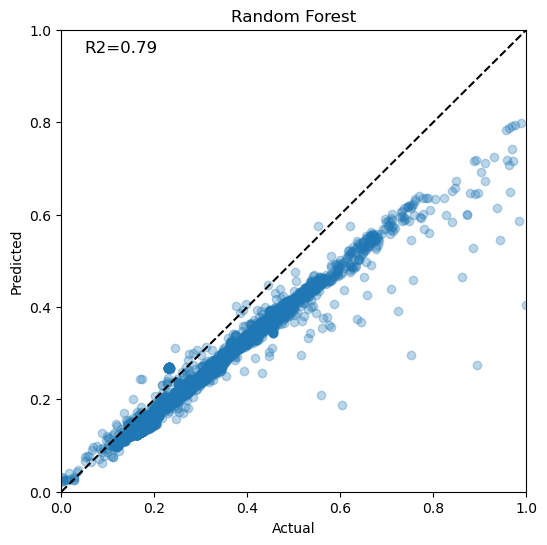

In [13]:
# Actual values
y_actual = y_test.squeeze()

# Create scatter plot for Random Forest
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([0, 1], [0, 1], 'k--')
ax.scatter(y_actual, test_preds, alpha=0.3)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title('Random Forest')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Display R-squared score
ax.text(0.05, 0.95, f'R2={r2:.2f}', transform=ax.transAxes, fontsize=12)

plt.show()

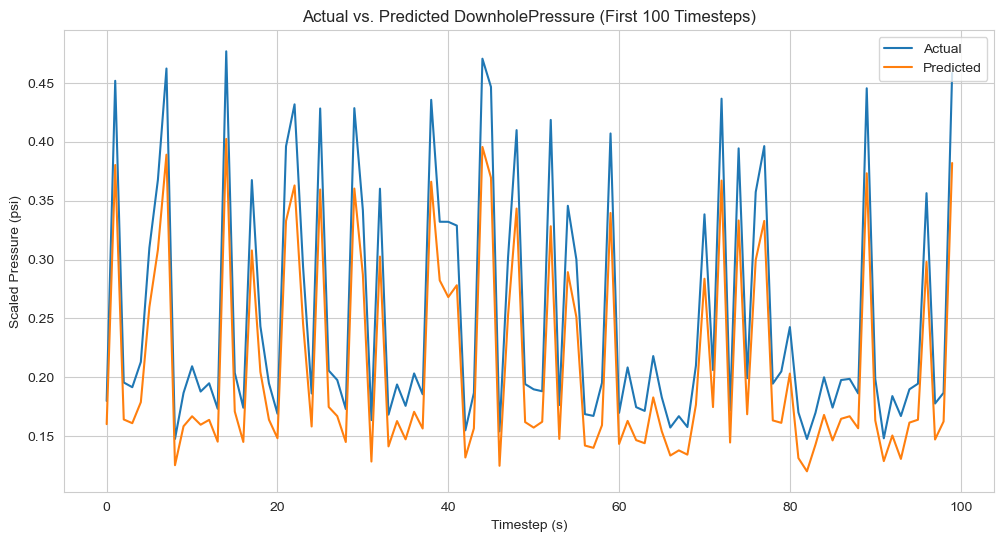

In [26]:
# Slice actual and predicted values for first 90 timesteps
y_test_first_90 = y_test[:100].values.ravel()  # Convert to 1D array
test_preds_90 = test_preds[:100]  # No need to reshape as it's already a 1D array

# Create a range for the x-axis
x_axis = range(0, 100)

# Set figure size to twice the width (e.g., (12, 6) instead of (6, 6))
plt.figure(figsize=(12, 6))

# Plot actual and predicted values for first 90 timesteps
plt.plot(x_axis, y_test_first_90, label='Actual')
plt.plot(x_axis, test_preds_90, label='Predicted')

# Add axis labels and title
plt.xlabel('Timestep (s)')
plt.ylabel('Scaled Pressure (psi)')
plt.title('Actual vs. Predicted DownholePressure (First 100 Timesteps)')

# Add legend
plt.legend()

# Display plot
plt.show()


### Second Best on Test set (XGB)

In [15]:
second_model = xgb  # Replace with the chosen best model
test_preds1 = second_model.predict(x_test)
test_mse1 = mean_squared_error(y_test, test_preds1)
test_rmse1 = np.sqrt(mean_squared_error(y_test, test_preds1))
r2_1 = r2_score(y_test, test_preds1)
mae1 = mean_absolute_error(y_test, test_preds1)

print("Test MSE:", test_mse1)
print("Test RMSE:", test_rmse1)
print("Mean Absolute Error (MAE):", mae1)
print("R-squared (R2) Score:", r2_1)

Test MSE: 0.002916433769419928
Test RMSE: 0.05400401623416473
Mean Absolute Error (MAE): 0.04914650292440574
R-squared (R2) Score: 0.7320728977697295


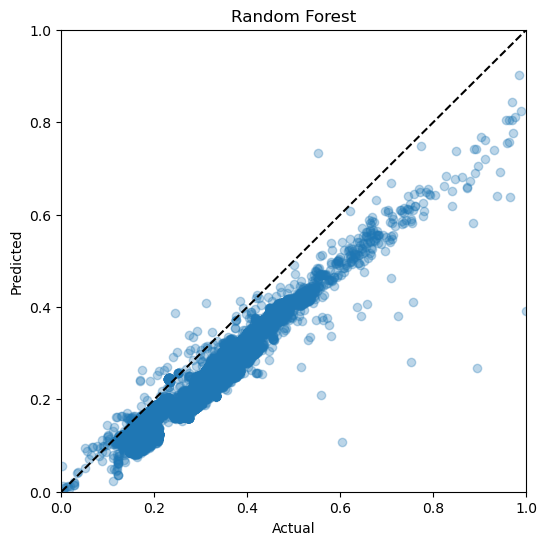

In [16]:
# Actual values
y_actual = y_test.squeeze()

# Create scatter plot for Random Forest
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(y_actual, test_preds1, alpha=0.3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

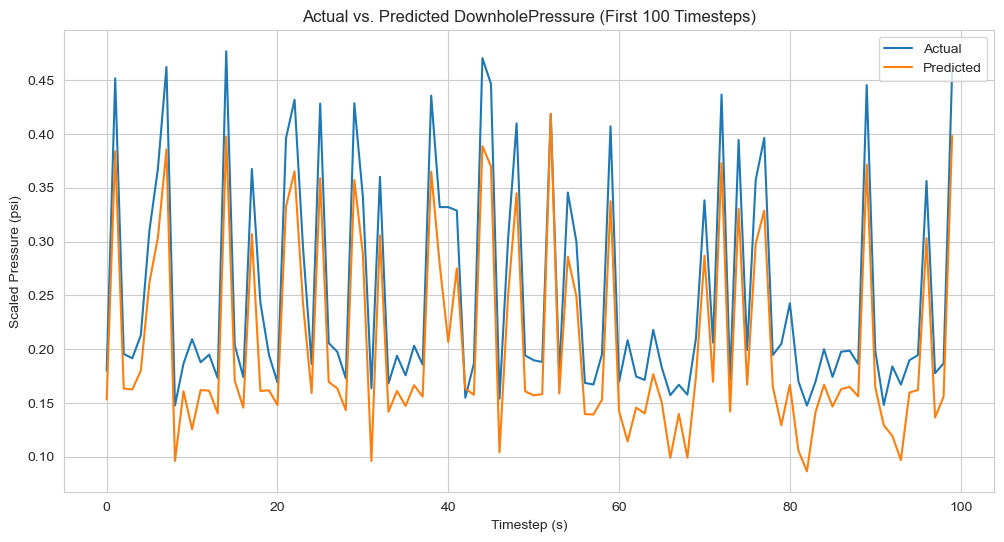

In [27]:
# Slice actual and predicted values for first 90 timesteps
y_test_first_90 = y_test[:100].values.ravel()  # Convert to 1D array
test_preds_90 = test_preds1[:100]  # No need to reshape as it's already a 1D array

# Create a range for the x-axis
x_axis = range(0, 100)

# Set figure size to twice the width (e.g., (12, 6) instead of (6, 6))
plt.figure(figsize=(12, 6))

# Plot actual and predicted values for first 90 timesteps
plt.plot(x_axis, y_test_first_90, label='Actual')
plt.plot(x_axis, test_preds_90, label='Predicted')

# Add axis labels and title
plt.xlabel('Timestep (s)')
plt.ylabel('Scaled Pressure (psi)')
plt.title('Actual vs. Predicted DownholePressure (First 100 Timesteps)')

# Add legend
plt.legend()

# Display plot
plt.show()

### Third Best on Test set (Ada Boost)

In [18]:
third_model = ada  # Replace with the chosen best model
test_preds2 = third_model.predict(x_test)
test_mse2 = mean_squared_error(y_test, test_preds2)
test_rmse2 = np.sqrt(mean_squared_error(y_test, test_preds2))
r2_2 = r2_score(y_test, test_preds2)
mae2 = mean_absolute_error(y_test, test_preds2)

print("Test MSE:", test_mse2)
print("Test RMSE:", test_rmse2)
print("Mean Absolute Error (MAE):", mae2)
print("R-squared (R2) Score:", r2_2)

Test MSE: 0.00238568623604429
Test RMSE: 0.04884348714050104
Mean Absolute Error (MAE): 0.040164097242988174
R-squared (R2) Score: 0.7808316421390494


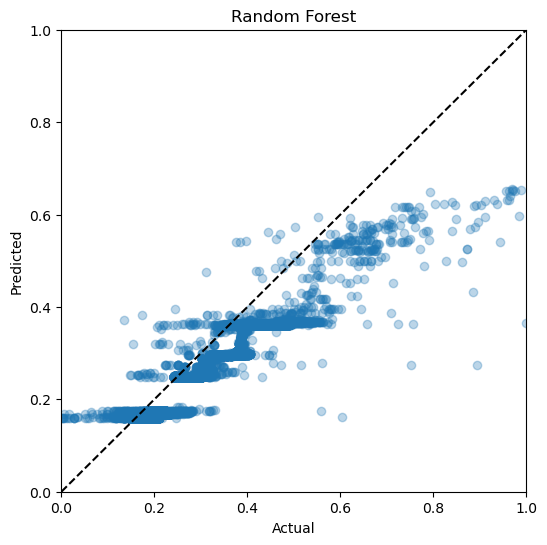

In [19]:
# Actual values
y_actual = y_test.squeeze()

# Create scatter plot for Random Forest
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(y_actual, test_preds2, alpha=0.3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

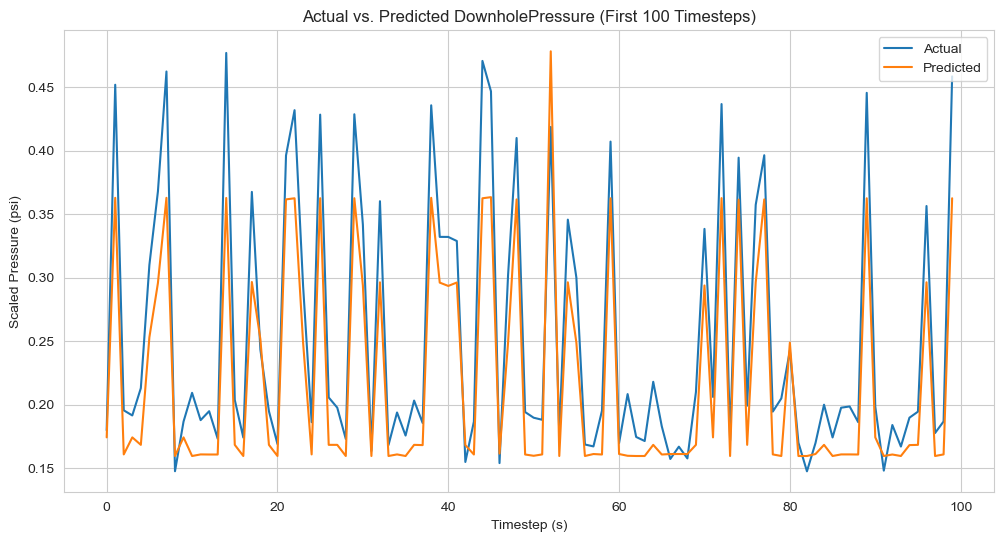

In [28]:
# Slice actual and predicted values for first 90 timesteps
y_test_first_90 = y_test[:100].values.ravel()  # Convert to 1D array
test_preds_90 = test_preds2[:100]  # No need to reshape as it's already a 1D array

# Create a range for the x-axis
x_axis = range(0, 100)

# Set figure size to twice the width (e.g., (12, 6) instead of (6, 6))
plt.figure(figsize=(12, 6))

# Plot actual and predicted values for first 90 timesteps
plt.plot(x_axis, y_test_first_90, label='Actual')
plt.plot(x_axis, test_preds_90, label='Predicted')

# Add axis labels and title
plt.xlabel('Timestep (s)')
plt.ylabel('Scaled Pressure (psi)')
plt.title('Actual vs. Predicted DownholePressure (First 100 Timesteps)')

# Add legend
plt.legend()

# Display plot
plt.show()

### Test of best model on new online unseen data

In [21]:
y_pred_validation = rf.predict(x_validation)

test_mse = mean_squared_error(y_validation, y_pred_validation)
test_rmse = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
r2 = r2_score(y_validation, y_pred_validation)
mae = mean_absolute_error(y_validation, y_pred_validation)

print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)

Test MSE: 0.020838328846908206
Test RMSE: 0.1443548712268076
Mean Absolute Error (MAE): 0.11823539149944305
R-squared (R2) Score: -1.6913805068605967


### Reshape and unscaling to get the actual values of the online data and the prediction

In [22]:
# Reshape the arrays to 2D arrays
y_pred_validation_2D = y_pred_validation.reshape(-1, 1)
y_validation_2D = y_validation.to_numpy().reshape(-1, 1)

# Assume target_index is the index of 'DownholePressure' in the original dataframe
target_index = 5

# Create dummy arrays for the non-target features
dummy_features_pred = np.zeros((y_pred_validation_2D.shape[0], scaler.n_features_in_))
dummy_features_val = np.zeros((y_validation_2D.shape[0], scaler.n_features_in_))

# Replace the column of the target feature with your validation data
dummy_features_pred[:, target_index] = y_pred_validation_2D.flatten()
dummy_features_val[:, target_index] = y_validation_2D.flatten()

# Invert the scaling of the predicted DownholePressure values and the actual values
y_pred_validation_inverted = scaler.inverse_transform(dummy_features_pred)[:, target_index]
y_validation_inverted = scaler.inverse_transform(dummy_features_val)[:, target_index]

### Plot of the actual vs prediction of the best model on the online data

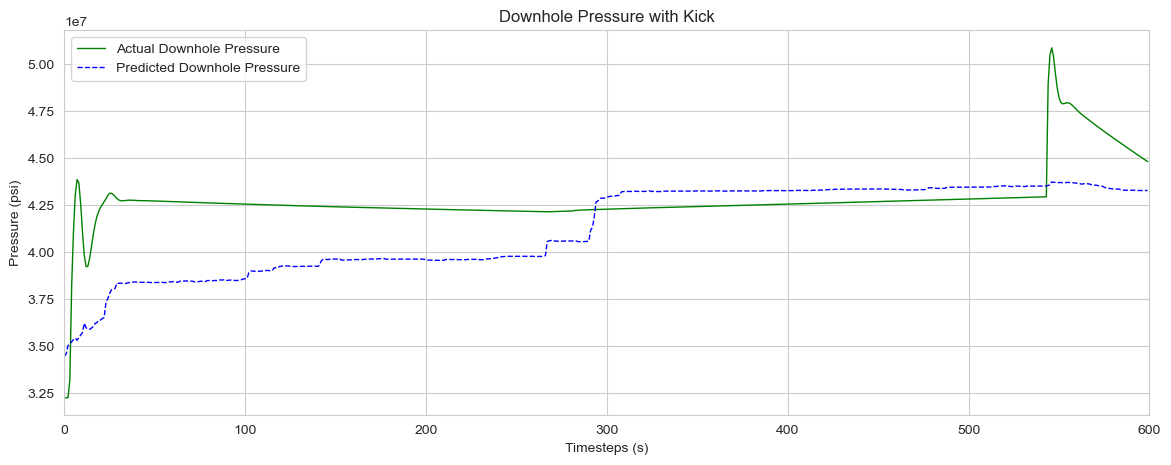

In [23]:
# Set the alpha value you want for your gridlines. 1 is opaque, 0 is transparent
alpha = 0.3

# Get the grid color
gridcolor = mpl.rcParams['grid.color']

# Convert the grid color to RGBA
rgba = mcolors.to_rgba(gridcolor)

# Create a new color with the adjusted alpha
new_color = (rgba[0], rgba[1], rgba[2], alpha)

# Convert the new color back to a hex string
new_color_hex = mcolors.to_hex(new_color)

# Set the new grid color
mpl.rcParams['grid.color'] = new_color_hex

# Set Seaborn style to 'whitegrid'
sns.set_style("whitegrid")

# Plot the two graphs
fig, ax = plt.subplots(figsize=(14,5))

# Plot the actual DownholePressure values
sns.lineplot(data=y_validation_inverted, color='green', label='Actual Downhole Pressure', linewidth=1)

# Plot the predicted DownholePressure values
sns.lineplot(data=y_pred_validation_inverted, color='blue', label='Predicted Downhole Pressure', linewidth=1, linestyle='--')

ax.set_title('Downhole Pressure with Kick')
ax.set_xlabel('Timesteps (s)')
ax.set_ylabel('Pressure (psi)')
ax.legend(loc='upper left', frameon=True)

# Zoom in on the first 600 seconds
ax.set_xlim(0, 600)

plt.show()